##### Imports

In [1]:
import preprocess
import sample
import nn
import cluster

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
%reload_ext autoreload
%autoreload 2

##### Read Data

In [2]:
classify = True
if classify:
    file = 'iris.csv'
    index_col, header = 0, 0
else:
    file = 'examen.csv'
    index_col, header = None, None

data, N_S, axes_names, indices = preprocess.get_data(file, header, index_col)
X_S, Y_S, revert_X, revert_Y = preprocess.preprocess(data, classify)

### Sample

##### PDF properties

In [3]:
pdf_info = sample.pdf_info(indices)

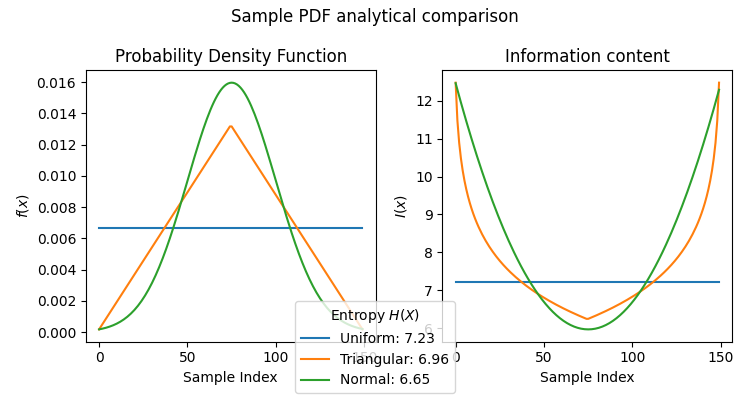

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 4), layout="tight")
fig.suptitle("Sample PDF analytical comparison")
ax[0].set_title("Probability Density Function")
ax[1].set_title("Information content")
cluster.axis_labels(ax[0], "Sample Index", "$f(x)$")
cluster.axis_labels(ax[1], "Sample Index", "$I(x)$")

for name, info in pdf_info.items():
    ax[0].plot(indices, info["F"], label=f"{name}: {info['H']:.2f}")
    ax[1].plot(indices, info["I"])
fig.legend(title="Entropy $H(X)$", loc="lower center")

##### Sampling data

In [5]:
p_sample = sample.sample(indices)
p_index = p_sample["Uniform"]
partition = {k: (X_S[:, v], Y_S[:, v]) for k, v in p_index.items()}

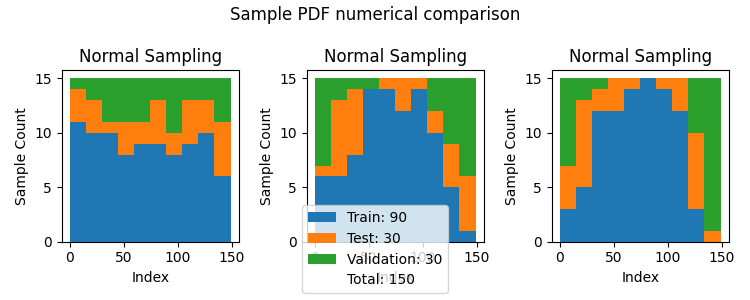

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(7.5, 3), layout="tight")
fig.suptitle("Sample PDF numerical comparison")
for ax_pdf, (name_pdf, partition_pdf) in zip(ax, p_sample.items()):
    ax_pdf.set_title(f"{name} Sampling")
    cluster.axis_labels(ax_pdf, 'Index', 'Sample Count')
    ax_pdf.hist(partition_pdf.values(), stacked=True, bins=10)
legend = fig.legend([f"{k}: {len(v)}" for k, v in p_index.items()]
                    + [f"Total: {N_S}"], loc="lower center")
legend.legendHandles[-1].set_visible(False)

### Neural Network

##### Train

In [7]:
hidden = [2, 2]
epochs = 1000

W, B, delta_nn, Y_nn, E_nn = nn.train(partition, "Train", 
    hidden=hidden, epochs=epochs, classify=classify, logs=True)

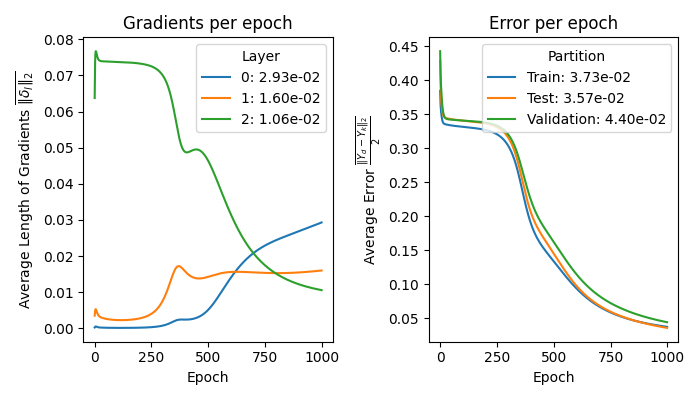

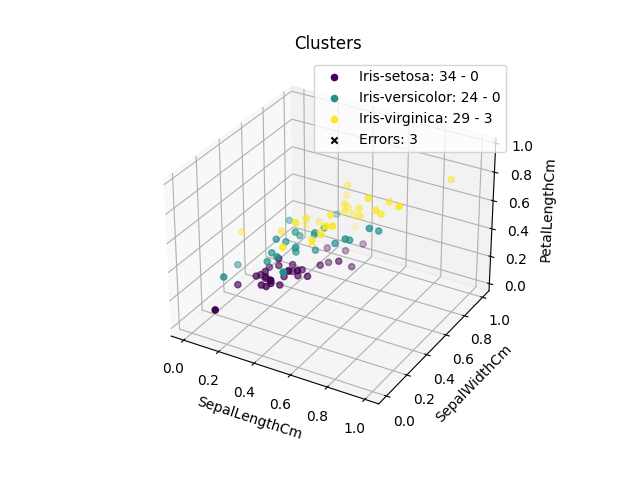

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4), layout="tight")
ax[0].set_title("Gradients per epoch")
ax[0].plot(range(epochs), delta_nn, 
        label=[f"{l}: {d:.2e}" for l, d in enumerate(delta_nn[-1])])
ax[0].legend(title="Layer")
cluster.axis_labels(ax[0], "Epoch",
    "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

ax[1].set_title("Error per epoch")
for p_name in p_index.keys():
    ax[1].plot(range(epochs), E_nn[p_name], 
        label=f"{p_name}: {E_nn[p_name][-1]:.2e}")
ax[1].legend(title="Partition")
cluster.axis_labels(ax[1], "Epoch",
    "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

cluster.plot(partition["Train"][0], Y_nn["Train"][-1], partition["Train"][1],
    axes_names=axes_names, cluster_names=revert_Y)
